In [21]:
import pandas as pd
import numpy as np
import rdkit.Chem
from rdkit import Chem
from rdkit.DataStructs import FingerprintSimilarity
from rdkit.Chem import rdMolDescriptors, Descriptors
from mordred import Calculator, descriptors
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.utils.validation import check_is_fitted
from sklearn.impute import KNNImputer
from sklearn.svm import SVR
from sklearn import tree
from sklearn import metrics
from math import floor
from eli5.sklearn import PermutationImportance
import seaborn as sns
import warnings; warnings.simplefilter('ignore')

In [22]:
df_acute = pd.read_csv("persistence_soil-preprocessed.csv")
print('there are',len(df_acute),'molecules in the dataset')
#####SOLUTION##### 
print('The columns are',df_acute.columns.values)

there are 226 molecules in the dataset
The columns are ['SMILES' 'y']


In [23]:
df_acute.SMILES[0]

'C(Cl)Br'

In [24]:
incorrect_indx = []

for i, smi in enumerate(df_acute.SMILES):
    try:
        sanitized_smi = Chem.MolToSmiles(Chem.MolFromSmiles(smi))
    except:
        incorrect_indx.append(i)
df_acute.drop(incorrect_indx,inplace=True)
df_acute.reset_index(drop=True)

df_acute.shape

(226, 2)

In [25]:
from rdkit.Chem import SaltRemover
remover = SaltRemover.SaltRemover()

i=0
for smile in df_acute['SMILES']:
    mol = Chem.MolFromSmiles(smile)
    res = remover.StripMol(mol, dontRemoveEverything=False)
    smi = Chem.MolToSmiles(res)
    
    df_acute.at[i,'no_salts'] = smi
    i+=1

df_acute

,SMILES,y,no_salts
0,C(Cl)Br,1.850238,ClCBr
1,C13(C4(C2(C5(C(C1(C2(Cl)Cl)Cl)(C3(C(C45Cl)(Cl)...,3.360152,ClC1(Cl)C2(Cl)C3(Cl)C4(Cl)C(Cl)(Cl)C5(Cl)C3(Cl...
2,O=C(O)C(Oc1ccc(cc1C)Cl)C,0.850238,Cc1cc(Cl)ccc1OC(C)C(=O)O
3,c1c(c(cc(c1C)C)C)C,1.850238,Cc1cc(C)c(C)cc1C
4,O=[N+]([O-])c1ccc(OP(OCC)(OCC)=S)cc1,1.360151,CCOP(=S)(OCC)Oc1ccc([N+](=O)[O-])cc1
...,...,...,...
221,O(C(C)CCl)C(C)CCl,1.360151,CC(CCl)OC(C)CCl
222,O1C(C)CNCC1C,2.173186,CC1CNCC(C)O1
223,O=Cc1ccccc1,0.360151,O=Cc1ccccc1
224,C(Cl)Cl,2.360152,ClCCl


In [26]:
no_water = []
for smi in df_acute.no_salts:
    new_smi = smi.replace('.[H+]', '').replace('[H+].', '')
    no_water.append(new_smi)
df_acute["no_salts"] = no_water

df_acute = df_acute[df_acute["no_salts"]!= '']
df_acute

,SMILES,y,no_salts
0,C(Cl)Br,1.850238,ClCBr
1,C13(C4(C2(C5(C(C1(C2(Cl)Cl)Cl)(C3(C(C45Cl)(Cl)...,3.360152,ClC1(Cl)C2(Cl)C3(Cl)C4(Cl)C(Cl)(Cl)C5(Cl)C3(Cl...
2,O=C(O)C(Oc1ccc(cc1C)Cl)C,0.850238,Cc1cc(Cl)ccc1OC(C)C(=O)O
3,c1c(c(cc(c1C)C)C)C,1.850238,Cc1cc(C)c(C)cc1C
4,O=[N+]([O-])c1ccc(OP(OCC)(OCC)=S)cc1,1.360151,CCOP(=S)(OCC)Oc1ccc([N+](=O)[O-])cc1
...,...,...,...
221,O(C(C)CCl)C(C)CCl,1.360151,CC(CCl)OC(C)CCl
222,O1C(C)CNCC1C,2.173186,CC1CNCC(C)O1
223,O=Cc1ccccc1,0.360151,O=Cc1ccccc1
224,C(Cl)Cl,2.360152,ClCCl


In [27]:
def retAtoms(mol):
    atomLs = []
    for atom in (mol.GetAtoms()):
        atomLs.append(atom.GetSymbol())
    return(atomLs)


allowed_atoms = ['H', 'N', 'C', 'O', 'P', 'S', 'Si', 'P', 'F', 'Cl', 'Br', 'I']
non_allowed_indx = []

i=0
for smile in df_acute['no_salts']:
    allow = True
    outCol = ''
    mol = Chem.MolFromSmiles(smile)
    atoms = retAtoms(mol)
    for letter in atoms:
        if letter not in allowed_atoms:
            allow = False
    if allow == False:
        non_allowed_indx.append(i)
    i+=1
print(non_allowed_indx)

df_acute.drop(non_allowed_indx,inplace=True)
df_acute.reset_index(drop=True)

df_acute

[]


,SMILES,y,no_salts
0,C(Cl)Br,1.850238,ClCBr
1,C13(C4(C2(C5(C(C1(C2(Cl)Cl)Cl)(C3(C(C45Cl)(Cl)...,3.360152,ClC1(Cl)C2(Cl)C3(Cl)C4(Cl)C(Cl)(Cl)C5(Cl)C3(Cl...
2,O=C(O)C(Oc1ccc(cc1C)Cl)C,0.850238,Cc1cc(Cl)ccc1OC(C)C(=O)O
3,c1c(c(cc(c1C)C)C)C,1.850238,Cc1cc(C)c(C)cc1C
4,O=[N+]([O-])c1ccc(OP(OCC)(OCC)=S)cc1,1.360151,CCOP(=S)(OCC)Oc1ccc([N+](=O)[O-])cc1
...,...,...,...
221,O(C(C)CCl)C(C)CCl,1.360151,CC(CCl)OC(C)CCl
222,O1C(C)CNCC1C,2.173186,CC1CNCC(C)O1
223,O=Cc1ccccc1,0.360151,O=Cc1ccccc1
224,C(Cl)Cl,2.360152,ClCCl


In [28]:
df_acute_clean = df_acute.loc[:,["no_salts","y"]]
df_acute_clean.rename(columns={"no_salts":"SMILES"},inplace=True)
df_acute_clean.to_excel('Soil_clean.xlsx')

In [29]:
#####SOLUTION##### 
i=0
remInd = []
for smi in df_acute_clean['SMILES']:
    if '.' in smi:
        remInd.append(i)
    i+=1
df_acute.drop(remInd,inplace=True)
df_acute.reset_index(drop=True)

,SMILES,y,no_salts
0,C(Cl)Br,1.850238,ClCBr
1,C13(C4(C2(C5(C(C1(C2(Cl)Cl)Cl)(C3(C(C45Cl)(Cl)...,3.360152,ClC1(Cl)C2(Cl)C3(Cl)C4(Cl)C(Cl)(Cl)C5(Cl)C3(Cl...
2,O=C(O)C(Oc1ccc(cc1C)Cl)C,0.850238,Cc1cc(Cl)ccc1OC(C)C(=O)O
3,c1c(c(cc(c1C)C)C)C,1.850238,Cc1cc(C)c(C)cc1C
4,O=[N+]([O-])c1ccc(OP(OCC)(OCC)=S)cc1,1.360151,CCOP(=S)(OCC)Oc1ccc([N+](=O)[O-])cc1
...,...,...,...
221,O(C(C)CCl)C(C)CCl,1.360151,CC(CCl)OC(C)CCl
222,O1C(C)CNCC1C,2.173186,CC1CNCC(C)O1
223,O=Cc1ccccc1,0.360151,O=Cc1ccccc1
224,C(Cl)Cl,2.360152,ClCCl


In [30]:
def duplicates(s_list):
    # Detect which molecules are present more than once in the list
    # Returns the list of all molecules and the list of duplicates
    uniqs = []
    dups = []
    for s in s_list:
        if s in uniqs:
            dups.append(s)
        else:
            uniqs.append(s)
    return uniqs, dups

uniq_smis, dup_smis = duplicates(df_acute_clean['SMILES'])
for i in dup_smis:
    df_acute_clean = df_acute_clean[df_acute_clean.SMILES != i]
    
df_acute_clean = df_acute_clean.reset_index(drop=True)
df_acute = df_acute_clean
df_acute

,SMILES,y
0,ClCBr,1.850238
1,ClC1(Cl)C2(Cl)C3(Cl)C4(Cl)C(Cl)(Cl)C5(Cl)C3(Cl...,3.360152
2,Cc1cc(Cl)ccc1OC(C)C(=O)O,0.850238
3,Cc1cc(C)c(C)cc1C,1.850238
4,CCOP(=S)(OCC)Oc1ccc([N+](=O)[O-])cc1,1.360151
...,...,...
221,CC(CCl)OC(C)CCl,1.360151
222,CC1CNCC(C)O1,2.173186
223,O=Cc1ccccc1,0.360151
224,ClCCl,2.360152


In [31]:
smis = list(df_acute['SMILES'])

df_acute_rdkit = pd.read_csv("persistence_soil-preprocessed.csv")

descriptor_names = list(rdMolDescriptors.Properties.GetAvailableProperties())

get_descriptors = rdMolDescriptors.Properties(descriptor_names)

print(descriptor_names)

def smi_to_descriptors(smile):
    mol = Chem.MolFromSmiles(smile)
    descriptors = []
    if mol:
        descriptors = get_descriptors.ComputeProperties(mol)
    return descriptors

df_acute_rdkit[descriptor_names] = list(df_acute_rdkit.SMILES.apply(smi_to_descriptors))
print(df_acute_rdkit)

['exactmw', 'amw', 'lipinskiHBA', 'lipinskiHBD', 'NumRotatableBonds', 'NumHBD', 'NumHBA', 'NumHeavyAtoms', 'NumAtoms', 'NumHeteroatoms', 'NumAmideBonds', 'FractionCSP3', 'NumRings', 'NumAromaticRings', 'NumAliphaticRings', 'NumSaturatedRings', 'NumHeterocycles', 'NumAromaticHeterocycles', 'NumSaturatedHeterocycles', 'NumAliphaticHeterocycles', 'NumSpiroAtoms', 'NumBridgeheadAtoms', 'NumAtomStereoCenters', 'NumUnspecifiedAtomStereoCenters', 'labuteASA', 'tpsa', 'CrippenClogP', 'CrippenMR', 'chi0v', 'chi1v', 'chi2v', 'chi3v', 'chi4v', 'chi0n', 'chi1n', 'chi2n', 'chi3n', 'chi4n', 'hallKierAlpha', 'kappa1', 'kappa2', 'kappa3', 'Phi']
                                                SMILES         y     exactmw  \
0                                              C(Cl)Br  1.850238  127.902840   
1    C13(C4(C2(C5(C(C1(C2(Cl)Cl)Cl)(C3(C(C45Cl)(Cl)...  3.360152  539.626232   
2                             O=C(O)C(Oc1ccc(cc1C)Cl)C  0.850238  214.039672   
3                                   c1c(c(

In [32]:
calc = Calculator(descriptors, ignore_3D = False)
mols = [Chem.MolFromSmiles(sm) for sm in smis]
df_calc = calc.pandas(mols)
print(df_calc)

100%|██████████| 226/226 [00:08<00:00, 27.26it/s]


           ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
0     1.414214   1.414214      0      0   2.828427  1.414214  2.828427   
1    18.965519  18.075527      0      0  27.062505  3.203127  6.108831   
2    10.365564   9.646951      1      0  16.532794  2.301365  4.602730   
3     7.427747   7.165349      0      0  11.683239  2.302776  4.605551   
4    13.065180  11.773866      0      0  21.249926  2.329965  4.659929   
..         ...        ...    ...    ...        ...       ...       ...   
221   5.875634   6.339087      0      0  10.290762  2.074313  4.148627   
222   5.875634   5.566041      0      1   9.431148  2.175328  4.350655   
223   5.656854   5.427660      0      0  10.424292  2.135779  4.271558   
224   1.414214   1.414214      0      0   2.828427  1.414214  2.828427   
225   2.449490   2.449490      0      0   3.464102  1.732051  3.464102   

        SpAD_A   SpMAD_A   LogEE_A  ...      SRW10     TSRW10          MW  \
0     2.828427  0.942809  1.849457

In [33]:
df_acute_final = pd.concat([df_acute_rdkit,df_calc], axis = 1)
print(df_acute_final)
df_acute_final.to_csv('Soil_descriptors.csv', index = False)

                                                SMILES         y     exactmw  \
0                                              C(Cl)Br  1.850238  127.902840   
1    C13(C4(C2(C5(C(C1(C2(Cl)Cl)Cl)(C3(C(C45Cl)(Cl)...  3.360152  539.626232   
2                             O=C(O)C(Oc1ccc(cc1C)Cl)C  0.850238  214.039672   
3                                   c1c(c(cc(c1C)C)C)C  1.850238  134.109550   
4                 O=[N+]([O-])c1ccc(OP(OCC)(OCC)=S)cc1  1.360151  291.033030   
..                                                 ...       ...         ...   
221                                  O(C(C)CCl)C(C)CCl  1.360151  170.026520   
222                                       O1C(C)CNCC1C  2.173186  115.099714   
223                                        O=Cc1ccccc1  0.360151  106.041865   
224                                            C(Cl)Cl  2.360152   83.953355   
225                                        C(Cl)(Cl)Cl  2.360152  117.914383   

         amw  lipinskiHBA  lipinskiHBD 

In [34]:
from sklearn.impute import KNNImputer

features = df_acute_final.iloc[:, 2:]

df_nan = features.replace(to_replace = r'[a-zA-Z]', value = np.nan, regex = True).replace(np.inf, np.nan)

to_cast = list(df_nan.select_dtypes(include=[object]).columns)
df_nan[to_cast] = df_nan[to_cast].astype(dtype=np.float64)

df_nan[df_nan <= -1e38] = np.nan
df_nan[df_nan >= 1e38] = np.nan

out_columns = list(features.columns)
all_nan=df_nan.columns[df_nan.isna().all()].tolist()

if len(all_nan)>0:
    #print('Warning! Some of descriptors are NaN along the full data set:', all_nan) 
    for i in df_nan.columns[df_nan.isna().all()].tolist(): 
        out_columns.remove(i) 

df_nan = df_nan.dropna(axis=1, how='all')
df_nan = df_nan.round(3)

imputer = KNNImputer(missing_values=np.nan, n_neighbors=3, weights="uniform")

result0 = imputer.fit(df_nan)

result = imputer.transform(df_nan)
imputed_df = pd.DataFrame(result, columns = out_columns)

df_acute_imputation = pd.concat([df_acute,imputed_df], axis = 1)
print(df_acute_imputation)

df_acute_imputation.to_csv('Soil_imputation.csv', index = False)
df_acute = df_acute_imputation

                                                SMILES         y  exactmw  \
0                                                ClCBr  1.850238  127.903   
1    ClC1(Cl)C2(Cl)C3(Cl)C4(Cl)C(Cl)(Cl)C5(Cl)C3(Cl...  3.360152  539.626   
2                             Cc1cc(Cl)ccc1OC(C)C(=O)O  0.850238  214.040   
3                                     Cc1cc(C)c(C)cc1C  1.850238  134.110   
4                 CCOP(=S)(OCC)Oc1ccc([N+](=O)[O-])cc1  1.360151  291.033   
..                                                 ...       ...      ...   
221                                    CC(CCl)OC(C)CCl  1.360151  170.027   
222                                       CC1CNCC(C)O1  2.173186  115.100   
223                                        O=Cc1ccccc1  0.360151  106.042   
224                                              ClCCl  2.360152   83.953   
225                                          ClC(Cl)Cl  2.360152  117.914   

         amw  lipinskiHBA  lipinskiHBD  NumRotatableBonds  NumHBD  NumHBA  

In [35]:
df_descriptors = df_acute.iloc[:, 2:]
df_smiles = pd.DataFrame(df_acute['SMILES'])
df_y = pd.DataFrame(df_acute['y'])

In [36]:
finite_cols = np.isfinite(df_descriptors).all()


if sum(finite_cols) < len(df_descriptors.columns):
    print("There are infinites")
    booleans = list(finite_cols)
    to_drop = []
    for i,boolean in enumerate(booleans):
        if boolean == False:
            to_drop.append(i)  
    df_descriptors = df_descriptors.drop(df_descriptors.columns[to_drop], axis=1)
else:
    print("There are no infinites")

There are no infinites


In [37]:
i=0
dropls = []
for count in df_descriptors.nunique():
    if count <= 1:
        dropls.append(df_descriptors.columns[i])
    i+=1

print('There are {} constant descriptors'.format(len(dropls)))
#Uncomment and save the resulting df in the following variable
df_descriptors = df_descriptors.drop(dropls,axis=1)

There are 194 constant descriptors


In [38]:
missing_threshold = 0.00000000001
nulldf = pd.isnull(df_descriptors)
i=0
dropls = []
for col in nulldf:
    column = nulldf[col]
    cval = column.sum()/len(column)
    if cval>missing_threshold:
        dropls.append(i)
    i+=1
dropls
#Uncomment and save the resulting df in the following variable
df_descriptors = df_descriptors.drop(dropls,axis=1)

In [39]:
correl_threshold = 0.9

def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr().abs()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
    return dataset
    
df_descriptors = correlation(df_descriptors, correl_threshold)
print(df_descriptors)

     exactmw  lipinskiHBA  lipinskiHBD  NumRotatableBonds  NumHeavyAtoms  \
0    127.903          0.0          0.0                0.0            3.0   
1    539.626          0.0          0.0                0.0           22.0   
2    214.040          3.0          1.0                3.0           14.0   
3    134.110          0.0          0.0                0.0           10.0   
4    291.033          6.0          0.0                7.0           18.0   
..       ...          ...          ...                ...            ...   
221  170.027          1.0          0.0                4.0            9.0   
222  115.100          2.0          1.0                0.0            8.0   
223  106.042          1.0          0.0                1.0            8.0   
224   83.953          0.0          0.0                0.0            3.0   
225  117.914          0.0          0.0                0.0            4.0   

     NumAtoms  NumHeteroatoms  NumAmideBonds  FractionCSP3  NumRings  ...  \
0         

In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

data = scaler.fit_transform(df_descriptors)
df_scaled_descr = pd.DataFrame(data, index=df_descriptors.index, columns=df_descriptors.columns)
df_scaled_descr

,exactmw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHeavyAtoms,NumAtoms,NumHeteroatoms,NumAmideBonds,FractionCSP3,NumRings,...,JGI6,JGI7,JGI8,JGI9,JGI10,JGT10,Diameter,TopoShapeIndex,SRW07,mZagreb1
0,-0.717656,-0.715910,-0.457871,-0.657385,-1.671535,-1.779787,-0.382587,-0.222971,1.788555,-1.141643,...,-0.828795,-0.673644,-0.481961,-0.207875,-0.149861,-1.132887,-1.648325,1.146453,-0.324039,-1.109944
1,3.462310,-0.715910,-0.457871,-0.657385,1.935285,0.208565,3.443286,-0.222971,1.788555,3.900922,...,-0.828795,-0.673644,-0.481961,-0.207875,-0.149861,2.492083,-0.059747,-0.792964,4.145152,3.502389
2,0.156839,1.115740,1.238503,0.757558,0.416624,0.559450,0.382587,-0.222971,-0.045706,-0.301215,...,0.848360,2.828893,-0.481961,-0.207875,-0.149861,0.987972,0.734542,1.146453,-0.324039,0.804341
3,-0.654640,-0.715910,-0.457871,-0.657385,-0.342707,0.442488,-1.147762,-0.222971,0.216331,-0.301215,...,-0.828795,-0.673644,-0.481961,-0.207875,-0.149861,0.975386,-0.456892,-0.145199,-0.324039,0.087707
4,0.938501,2.947389,-0.457871,2.644149,1.175954,1.378183,1.912937,-0.222971,0.216331,-0.301215,...,0.619657,2.245137,1.402990,3.810137,-0.149861,0.811759,1.528831,1.146453,-0.324039,1.288914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,-0.289997,-0.105360,-0.457871,1.229206,-0.532539,0.091603,0.000000,-0.222971,1.788555,-1.141643,...,-0.828795,-0.673644,-0.481961,-0.207875,-0.149861,0.616665,-0.059747,1.146453,-0.324039,0.100154
222,-0.847637,0.505190,1.238503,-0.657385,-0.722372,0.091603,-0.382587,-0.222971,1.788555,-0.301215,...,-0.828795,-0.673644,-0.481961,-0.207875,-0.149861,0.201304,-0.854036,-1.440729,-0.324039,-0.677830
223,-0.939597,-0.105360,-0.457871,-0.185737,-0.722372,-0.727130,-0.765175,-0.222971,-0.831818,-0.301215,...,-0.828795,-0.673644,-0.481961,-0.207875,-0.149861,-0.730112,-0.456892,-0.145199,-0.324039,-0.949457
224,-1.163853,-0.715910,-0.457871,-0.657385,-1.671535,-1.779787,-0.382587,-0.222971,1.788555,-1.141643,...,-0.828795,-0.673644,-0.481961,-0.207875,-0.149861,-1.132887,-1.648325,1.146453,-0.324039,-1.109944


In [41]:
df_transformed = pd.concat([df_smiles, df_y, df_scaled_descr], axis=1, join='inner')
df_transformed

,SMILES,y,exactmw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHeavyAtoms,NumAtoms,NumHeteroatoms,NumAmideBonds,...,JGI6,JGI7,JGI8,JGI9,JGI10,JGT10,Diameter,TopoShapeIndex,SRW07,mZagreb1
0,ClCBr,1.850238,-0.717656,-0.715910,-0.457871,-0.657385,-1.671535,-1.779787,-0.382587,-0.222971,...,-0.828795,-0.673644,-0.481961,-0.207875,-0.149861,-1.132887,-1.648325,1.146453,-0.324039,-1.109944
1,ClC1(Cl)C2(Cl)C3(Cl)C4(Cl)C(Cl)(Cl)C5(Cl)C3(Cl...,3.360152,3.462310,-0.715910,-0.457871,-0.657385,1.935285,0.208565,3.443286,-0.222971,...,-0.828795,-0.673644,-0.481961,-0.207875,-0.149861,2.492083,-0.059747,-0.792964,4.145152,3.502389
2,Cc1cc(Cl)ccc1OC(C)C(=O)O,0.850238,0.156839,1.115740,1.238503,0.757558,0.416624,0.559450,0.382587,-0.222971,...,0.848360,2.828893,-0.481961,-0.207875,-0.149861,0.987972,0.734542,1.146453,-0.324039,0.804341
3,Cc1cc(C)c(C)cc1C,1.850238,-0.654640,-0.715910,-0.457871,-0.657385,-0.342707,0.442488,-1.147762,-0.222971,...,-0.828795,-0.673644,-0.481961,-0.207875,-0.149861,0.975386,-0.456892,-0.145199,-0.324039,0.087707
4,CCOP(=S)(OCC)Oc1ccc([N+](=O)[O-])cc1,1.360151,0.938501,2.947389,-0.457871,2.644149,1.175954,1.378183,1.912937,-0.222971,...,0.619657,2.245137,1.402990,3.810137,-0.149861,0.811759,1.528831,1.146453,-0.324039,1.288914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,CC(CCl)OC(C)CCl,1.360151,-0.289997,-0.105360,-0.457871,1.229206,-0.532539,0.091603,0.000000,-0.222971,...,-0.828795,-0.673644,-0.481961,-0.207875,-0.149861,0.616665,-0.059747,1.146453,-0.324039,0.100154
222,CC1CNCC(C)O1,2.173186,-0.847637,0.505190,1.238503,-0.657385,-0.722372,0.091603,-0.382587,-0.222971,...,-0.828795,-0.673644,-0.481961,-0.207875,-0.149861,0.201304,-0.854036,-1.440729,-0.324039,-0.677830
223,O=Cc1ccccc1,0.360151,-0.939597,-0.105360,-0.457871,-0.185737,-0.722372,-0.727130,-0.765175,-0.222971,...,-0.828795,-0.673644,-0.481961,-0.207875,-0.149861,-0.730112,-0.456892,-0.145199,-0.324039,-0.949457
224,ClCCl,2.360152,-1.163853,-0.715910,-0.457871,-0.657385,-1.671535,-1.779787,-0.382587,-0.222971,...,-0.828795,-0.673644,-0.481961,-0.207875,-0.149861,-1.132887,-1.648325,1.146453,-0.324039,-1.109944


In [42]:

SEED = 300
test_s = 0.3

df_transformed = pd.concat([df_smiles, df_y, df_scaled_descr], axis=1, join='inner')
df_transformed

df_train, df_test= train_test_split(df_transformed, test_size=test_s, random_state=SEED)

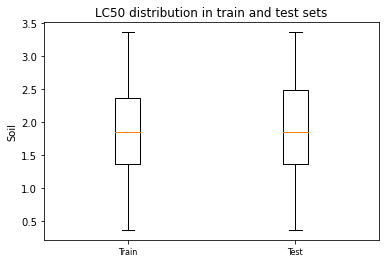

In [43]:
plot_df = [list(df_train.y), list(df_test.y)]
fig, ax = plt.subplots()
ax.set_title('LC50 distribution in train and test sets')
plt.ylabel("Soil")
ax.set_xticklabels(["Train","Test"], fontsize=8)
ax.boxplot(plot_df)

plt.show()

In [44]:
df_train.to_csv("Soil_Train.csv", index=False)
df_test.to_csv("Soil_Test.csv", index=False)

In [45]:

#Read the train set and separate the descriptors array and the output variable
df_train = pd.read_csv("Soil_Train.csv")
X = df_train.iloc[:,2:]
y = df_train.pop("y")

estimator = LinearRegression()

num_features = floor(len(df_train)/5)
#Instantiate the RFE selector
selector = RFE(estimator, n_features_to_select=num_features, step=1)
#Fit the RFE selector to the training data
selector = selector.fit(X,y)

#Subset the descriptors dataset 
feats_train_rfe3 = X.loc[:, selector.support_]
#Join the selected descriptors to the output variable and SMILES column
df_train_rfe3 = pd.concat([df_train.SMILES, y, feats_train_rfe3], axis=1)

#Read the test set and select only descriptor columns of interest
df_test = pd.read_csv("Soil_Test.csv")
descr_test = df_test.loc[:,list(feats_train_rfe3.columns)]
df_test_rfe3 = pd.concat([df_test.loc[:,["SMILES","y"]], descr_test], axis=1)

print("The features selected are:")
for feat in list(feats_train_rfe3.columns):
    print("\n",feat)


#Uncomment to save both datasets as csv files
df_train_rfe3.to_csv("Soil_Train_RFE_linreg.csv", index=False)
df_test_rfe3.to_csv("Soil_Test_RFE_linreg.csv", index=False)

The features selected are:

 lipinskiHBD

 ATSC3Z

 ATSC1v

 AATSC1c

 AATSC7c

 AATSC6dv

 AATSC7s

 GATS4dv

 GATS4s

 GATS7Z

 BCUTdv-1l

 BCUTs-1h

 BCUTv-1l

 BalabanJ

 AXp-4d

 AXp-5d

 NdsCH

 NaaaC

 NdsN

 NssS

 MAXdsN

 MAXaaN

 MAXdS

 MAXssS

 Lipinski

 SMR_VSA9

 SlogP_VSA10

 VSA_EState5

 VSA_EState7

 AMID_O

 n10FARing


In [46]:
#Read the train set and separate the descriptors array and the output variable
df_train = pd.read_csv("Soil_Train.csv")
X = df_train.iloc[:,2:]
y = df_train.pop("y")

estimator = tree.DecisionTreeRegressor()

num_features = floor(len(df_train)/5)
#Instantiate the RFE selector
selector = RFE(estimator, n_features_to_select=num_features, step=1)
#Fit the RFE selector to the training data
selector = selector.fit(X,y)

#Subset the descriptors dataset 
feats_train_rfe4 = X.loc[:, selector.support_]
#Join the selected descriptors to the output variable and SMILES column
df_train_rfe4 = pd.concat([df_train.SMILES, y, feats_train_rfe4], axis=1)

#Read the test set and select only descriptor columns of interest
df_test = pd.read_csv("Soil_Test.csv")
descr_test = df_test.loc[:,list(feats_train_rfe4.columns)]
df_test_rfe4 = pd.concat([df_test.loc[:,["SMILES","y"]], descr_test], axis=1)

print("The features selected are:")
for feat in list(feats_train_rfe4.columns):
    print("\n",feat)

#Uncomment to save both datasets as csv files
df_train_rfe4.to_csv("Soil_Train_RFE_dectree.csv", index=False)
df_test_rfe4.to_csv("Soil_Test_RFE_dectree.csv", index=False)

The features selected are:

 kappa2

 nBase

 SpMax_A

 SpMAD_A

 VR1_A

 nH

 nC

 nN

 nO

 nCl

 ATS4s

 ATS6Z

 AATS6v

 AATS0i

 AATS4i

 ATSC1se

 AATSC3s

 GATS1d

 GATS4d

 GATS1se

 BCUTs-1h

 BCUTs-1l

 BCUTZ-1h

 BCUTZ-1l

 BCUTse-1h

 BCUTpe-1l

 BCUTi-1h

 RPCG

 NssNH

 EState_VSA7

 EState_VSA8


In [47]:
#Read the train set and separate the descriptors array and the output variable
df_train = pd.read_csv("Soil_Train.csv")
X = df_train.iloc[:,2:]
y = df_train.pop("y")

estimator = LinearRegression()

estimator.fit(X, y)
perm = PermutationImportance(estimator).fit(X, y)

#We use the attribute perm.feature_importances_ for feature selection 
#let's e.g. select features which increase accuracy by at least 0.01:
sel = SelectFromModel(perm, threshold=0.01, prefit=True)

#Get the features and importances in a dataframe and sort them to see which ones are most important
importances_ = list(perm.feature_importances_)
features__permutation = list(X.columns)

dataframe_permutation = pd.DataFrame({'feature' : features__permutation,
                            'importance' : importances_},
                            columns=['feature','importance'])

dataframe_permutation_ordered = dataframe_permutation.sort_values('importance',ascending=False)

print(dataframe_permutation_ordered)

      feature    importance
505  Lipinski  2.748089e-02
278    MATS4s  2.326416e-02
339    GATS5v  2.295388e-02
427      NdsN  1.941141e-02
417     NdsCH  1.639100e-02
..        ...           ...
585   nFHRing  1.475793e-09
463     MAXsF  3.459899e-12
438      NaaS  0.000000e+00
467    MAXaaS  0.000000e+00
26      nBase  0.000000e+00

[620 rows x 2 columns]


Number of important features: 58


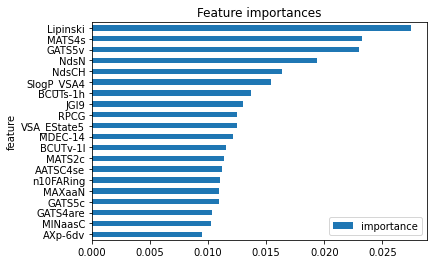

In [48]:
%matplotlib inline

df = dataframe_permutation_ordered

df = df[df.importance > 0.005]

df_plot = df.iloc[:20,:].sort_values('importance',ascending=True)

df_plot.plot(
    x="feature",
    kind = "barh",
    stacked = False,
    title = "Feature importances")

pi_n_feats = len(df)

print('Number of important features:',pi_n_feats)

In [49]:

#Read the train set and separate the descriptors array and the output variable
df_train = pd.read_csv("Soil_Train.csv")
X = df_train.iloc[:,2:]
y = df_train.pop("y")

estimator = SVR()

estimator.fit(X, y)
perm = PermutationImportance(estimator).fit(X, y)

#We use the attribute perm.feature_importances_ for feature selection 
#let's e.g. select features which increase accuracy by at least 0.01:
sel = SelectFromModel(perm, threshold=0.01, prefit=True)

#Get the features and importances in a dataframe and sort them to see which ones are most important
importances_ = list(perm.feature_importances_)
features__permutation = list(X.columns)

dataframe_permutation = pd.DataFrame({'feature' : features__permutation,
                            'importance' : importances_},
                            columns=['feature','importance'])

dataframe_permutation_ordered = dataframe_permutation.sort_values('importance',ascending=False)

print(dataframe_permutation_ordered)

      feature  importance
90     AATS0i    1.298417
200   AATSC3s    0.413595
368  BCUTs-1h    0.330038
23     kappa2    0.184701
82     AATS6v    0.148016
..        ...         ...
214   AATSC8Z    0.000000
215   AATSC0v    0.000000
216   AATSC1v    0.000000
217   AATSC2v    0.000000
619  mZagreb1    0.000000

[620 rows x 2 columns]


Number of important features: 25


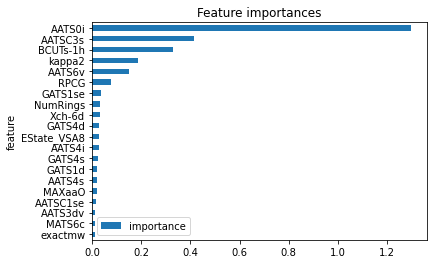

In [50]:
%matplotlib inline

df = dataframe_permutation_ordered

df = df[df.importance > 0.005]

df_plot = df.iloc[:20,:].sort_values('importance',ascending=True)

df_plot.plot(
    x="feature",
    kind = "barh",
    stacked = False,
    title = "Feature importances")

pi_n_feats = len(df)

print('Number of important features:',pi_n_feats)

In [51]:
pi_n_feats = 24
featList = list(dataframe_permutation_ordered[:pi_n_feats]['feature'])
df_train[featList]

#Uncomment and save the resulting train and test df in the following variables
### (Remember to save a dataframe with the corresponding column names)
df_train = pd.read_csv("Soil_Train.csv")
df_train_pi4 = pd.concat([df_train.loc[:,["SMILES","y"]], df_train[featList]], axis=1)
df_test = pd.read_csv("Soil_Test.csv")
df_test_pi4 = pd.concat([df_test.loc[:,["SMILES","y"]], df_test[featList]], axis=1)

#Uncomment to save both datasets as csv files
df_train_pi4.to_csv("Soil_Train_PI_dectree.csv", index=False)
df_test_pi4.to_csv("Soil_Test_PI_dectree.csv", index=False)

In [52]:
df_acute = pd.read_csv("Soil_Train_RFE_linreg.csv")

X_train = df_acute.iloc[:, 2:]
Y_train = df_acute.iloc[:, 1]

model = LinearRegression()

#Applying the fit function to model 
model.fit(X_train, Y_train)
from sklearn.utils.validation import check_is_fitted
check_is_fitted(model)

Y_train_pred = model.predict(X_train)

df_test = pd.read_csv('Soil_Test_RFE_linreg.csv')

X_test = df_test.iloc[:, 2:]
Y_test = df_test.iloc[:, 1]


Y_test_pred = model.predict(X_test)

In [53]:
def regression_plot(y_obs,y_pred):
    fig, ax = plt.subplots(1)
    ax.scatter(y_obs, y_pred, s=5, color="blue", label="original")
    ax.set_xlabel('Observed')
    ax.set_ylabel('Predicted')
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    ax.plot(lims, lims, '-r')
    plt.show()
    
def regressor_assessment(Y_train,Y_train_pred):

    rsq = metrics.r2_score(Y_train,Y_train_pred)
    ev = metrics.explained_variance_score(Y_train,Y_train_pred)
    mse = metrics.mean_squared_error(Y_train,Y_train_pred)
    mae = metrics.mean_absolute_error(Y_train,Y_train_pred)
    
    print("R square:",rsq)
    print("Explained variance:",ev)
    print("Mean square error:",mse)
    print("Mean absolute error:",mae)
    
    #Round the values to make visualization easier
    return [rsq,ev,mse,mae]

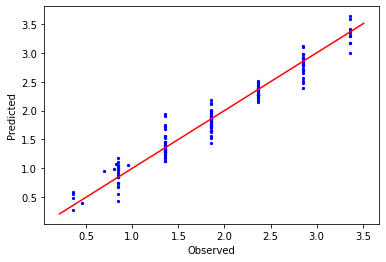

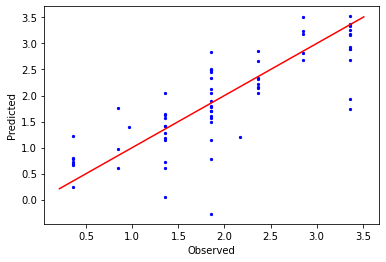

R square: 0.9480236501065398
Explained variance: 0.9480236501065398
Mean square error: 0.031193825960242158
Mean absolute error: 0.13427278275134422
R square: 0.5818244467677662
Explained variance: 0.5856188080406889
Mean square error: 0.3441604733489242
Mean absolute error: 0.42618812919430976


In [54]:
regression_plot(Y_train,Y_train_pred)
regression_plot(Y_test,Y_test_pred)

train_metrics = regressor_assessment(Y_train,Y_train_pred)
test_metrics = regressor_assessment(Y_test,Y_test_pred)

In [55]:
soil_comparison = {}

soil_comparison.update({"Linear Regression with RFE_linreg":[train_metrics,test_metrics]})

soil_comparison

{'Linear Regression with RFE_linreg': [[0.9480236501065398,
   0.9480236501065398,
   0.031193825960242158,
   0.13427278275134422],
  [0.5818244467677662,
   0.5856188080406889,
   0.3441604733489242,
   0.42618812919430976]]}

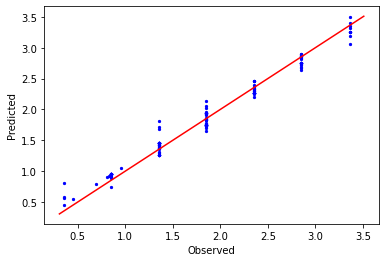

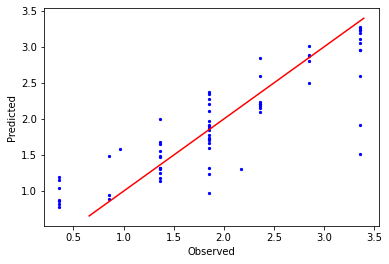

R square: 0.9761199165471138
Explained variance: 0.9762146710845627
Mean square error: 0.014331732964555807
Mean absolute error: 0.09827896537568243
R square: 0.7358849031079779
Explained variance: 0.7362924696454495
Mean square error: 0.21736798352359704
Mean absolute error: 0.3303390112222733


{'Linear Regression with RFE_linreg': [[0.9480236501065398,
   0.9480236501065398,
   0.031193825960242158,
   0.13427278275134422],
  [0.5818244467677662,
   0.5856188080406889,
   0.3441604733489242,
   0.42618812919430976]],
 'SVR': [[0.9761199165471138,
   0.9762146710845627,
   0.014331732964555807,
   0.09827896537568243],
  [0.7358849031079779,
   0.7362924696454495,
   0.21736798352359704,
   0.3303390112222733]]}

In [56]:
model = SVR()

model.fit(X_train, Y_train)
from sklearn.utils.validation import check_is_fitted
check_is_fitted(model)

Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

regression_plot(Y_train,Y_train_pred)
regression_plot(Y_test,Y_test_pred)

train_metric_values = regressor_assessment(Y_train, Y_train_pred)
test_metric_values = regressor_assessment(Y_test, Y_test_pred)

soil_comparison.update({"SVR":[train_metric_values,test_metric_values]})
soil_comparison

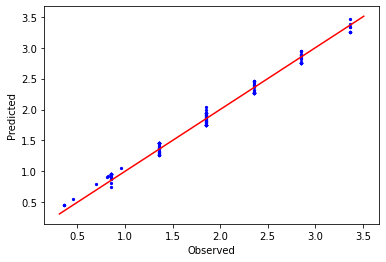

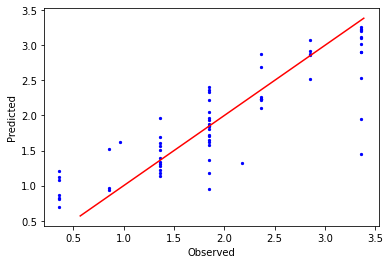

R square: 0.9872574377021811
Explained variance: 0.9873061522153779
Mean square error: 0.007647502593400025
Mean absolute error: 0.08129664185721032
R square: 0.7274465804659825
Explained variance: 0.7279826709121178
Mean square error: 0.2243127632752897
Mean absolute error: 0.3359440327322975


{'Linear Regression with RFE_linreg': [[0.9480236501065398,
   0.9480236501065398,
   0.031193825960242158,
   0.13427278275134422],
  [0.5818244467677662,
   0.5856188080406889,
   0.3441604733489242,
   0.42618812919430976]],
 'SVR': [[0.9761199165471138,
   0.9762146710845627,
   0.014331732964555807,
   0.09827896537568243],
  [0.7358849031079779,
   0.7362924696454495,
   0.21736798352359704,
   0.3303390112222733]],
 'SVR C5': [[0.9872574377021811,
   0.9873061522153779,
   0.007647502593400025,
   0.08129664185721032],
  [0.7274465804659825,
   0.7279826709121178,
   0.2243127632752897,
   0.3359440327322975]]}

In [57]:
model = SVR(C=5)

model.fit(X_train, Y_train)
from sklearn.utils.validation import check_is_fitted
check_is_fitted(model)

Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

regression_plot(Y_train,Y_train_pred)
regression_plot(Y_test,Y_test_pred)

train_metric_values = regressor_assessment(Y_train, Y_train_pred)
test_metric_values = regressor_assessment(Y_test, Y_test_pred)

soil_comparison.update({"SVR C5":[train_metric_values,test_metric_values]})
soil_comparison

R square: 0.9761199165471138
Explained variance: 0.9762146710845627
Mean square error: 0.014331732964555807
Mean absolute error: 0.09827896537568243
R square: 0.7358849031079779
Explained variance: 0.7362924696454495
Mean square error: 0.21736798352359704
Mean absolute error: 0.3303390112222733
R square: 0.9854904299301036
Explained variance: 0.985584654188544
Mean square error: 0.008707979772454811
Mean absolute error: 0.08423005509128421
R square: 0.7289767610169251
Explained variance: 0.7296171878648143
Mean square error: 0.22305341738897186
Mean absolute error: 0.3352170574996799
R square: 0.9865920998157088
Explained variance: 0.9866447956217473
Mean square error: 0.008046807936655461
Mean absolute error: 0.08258867901673606
R square: 0.7276789691105383
Explained variance: 0.728282342374168
Mean square error: 0.22412150631324823
Mean absolute error: 0.3372235424984172
R square: 0.9870278171344822
Explained variance: 0.9870820566260992
Mean square error: 0.007785310347126002
Mean a

<AxesSubplot:xlabel='C'>

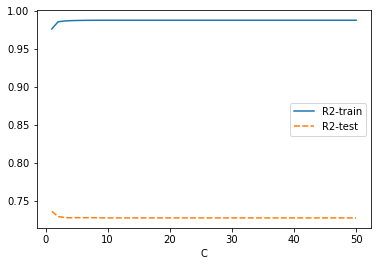

In [58]:
c_values=[]
rsqs_train=[]
rsqs_test=[]
for c in range(50):
    c+=1
    
    model = SVR(C=c)

    model.fit(X_train, Y_train)
    from sklearn.utils.validation import check_is_fitted
    check_is_fitted(model)

    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)

    train_metric_values = regressor_assessment(Y_train, Y_train_pred)
    test_metric_values = regressor_assessment(Y_test, Y_test_pred)
    
    
    
    #use append to update lists
    c_values.append(c)
    rsqs_train.append(train_metric_values[0])
    rsqs_test.append(test_metric_values[0])

    
# Keep this code to visualize results in a table and a graph    
res_df = pd.DataFrame({'C':c_values,'R2-train':rsqs_train,"R2-test":rsqs_test}).set_index('C')
import seaborn as sns
sns.lineplot(data=res_df)

In [59]:
cval = int(res_df.sort_values('R2-test', axis=0, ascending=False).iloc[0].name)

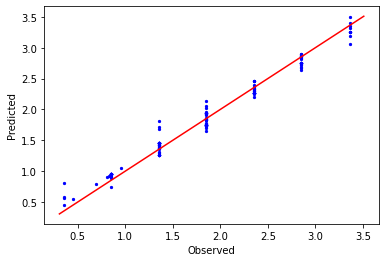

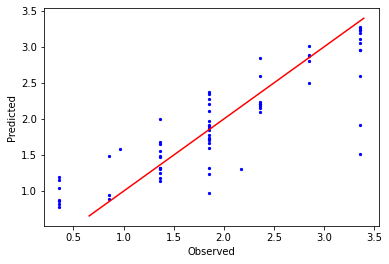

R square: 0.9761199165471138
Explained variance: 0.9762146710845627
Mean square error: 0.014331732964555807
Mean absolute error: 0.09827896537568243
R square: 0.7358849031079779
Explained variance: 0.7362924696454495
Mean square error: 0.21736798352359704
Mean absolute error: 0.3303390112222733


{'Linear Regression with RFE_linreg': [[0.9480236501065398,
   0.9480236501065398,
   0.031193825960242158,
   0.13427278275134422],
  [0.5818244467677662,
   0.5856188080406889,
   0.3441604733489242,
   0.42618812919430976]],
 'SVR': [[0.9761199165471138,
   0.9762146710845627,
   0.014331732964555807,
   0.09827896537568243],
  [0.7358849031079779,
   0.7362924696454495,
   0.21736798352359704,
   0.3303390112222733]],
 'SVR C5': [[0.9872574377021811,
   0.9873061522153779,
   0.007647502593400025,
   0.08129664185721032],
  [0.7274465804659825,
   0.7279826709121178,
   0.2243127632752897,
   0.3359440327322975]],
 'SVR C1 (algorithm)': [[0.9761199165471138,
   0.9762146710845627,
   0.014331732964555807,
   0.09827896537568243],
  [0.7358849031079779,
   0.7362924696454495,
   0.21736798352359704,
   0.3303390112222733]]}

In [60]:
model = SVR(C=cval)

model.fit(X_train, Y_train)
from sklearn.utils.validation import check_is_fitted
check_is_fitted(model)

Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

regression_plot(Y_train,Y_train_pred)
regression_plot(Y_test,Y_test_pred)

train_metric_values = regressor_assessment(Y_train, Y_train_pred)
test_metric_values = regressor_assessment(Y_test, Y_test_pred)

soil_comparison.update({"SVR C{} (algorithm)".format(cval):[train_metric_values,test_metric_values]})
soil_comparison

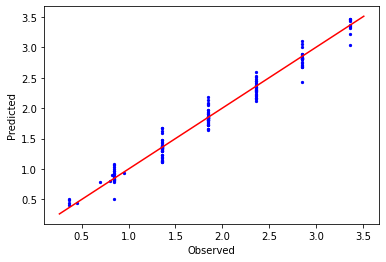

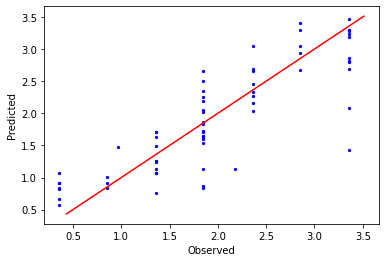

R square: 0.971441722161819
Explained variance: 0.9714821076234118
Mean square error: 0.0171393710877059
Mean absolute error: 0.09762963147719736
R square: 0.6997181032501383
Explained variance: 0.7022777787774609
Mean square error: 0.24713343217878747
Mean absolute error: 0.3697899781617585


{'Linear Regression with RFE_linreg': [[0.9480236501065398,
   0.9480236501065398,
   0.031193825960242158,
   0.13427278275134422],
  [0.5818244467677662,
   0.5856188080406889,
   0.3441604733489242,
   0.42618812919430976]],
 'SVR': [[0.9761199165471138,
   0.9762146710845627,
   0.014331732964555807,
   0.09827896537568243],
  [0.7358849031079779,
   0.7362924696454495,
   0.21736798352359704,
   0.3303390112222733]],
 'SVR C5': [[0.9872574377021811,
   0.9873061522153779,
   0.007647502593400025,
   0.08129664185721032],
  [0.7274465804659825,
   0.7279826709121178,
   0.2243127632752897,
   0.3359440327322975]],
 'SVR C1 (algorithm)': [[0.9761199165471138,
   0.9762146710845627,
   0.014331732964555807,
   0.09827896537568243],
  [0.7358849031079779,
   0.7362924696454495,
   0.21736798352359704,
   0.3303390112222733]],
 'Neural': [[0.971441722161819,
   0.9714821076234118,
   0.0171393710877059,
   0.09762963147719736],
  [0.6997181032501383,
   0.7022777787774609,
   0.2471334

In [61]:
model = MLPRegressor(max_iter=500)

model.fit(X_train, Y_train)
from sklearn.utils.validation import check_is_fitted
check_is_fitted(model)

Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

regression_plot(Y_train,Y_train_pred)
regression_plot(Y_test,Y_test_pred)

train_metric_values = regressor_assessment(Y_train, Y_train_pred)
test_metric_values = regressor_assessment(Y_test, Y_test_pred)

soil_comparison.update({"Neural":[train_metric_values,test_metric_values]})
soil_comparison

In [62]:
df_acute = pd.read_csv("Soil_Train_PI_dectree.csv")

X_train = df_acute.iloc[:, 2:]
Y_train = df_acute.iloc[:, 1]

model = LinearRegression()

#Applying the fit function to model 
model.fit(X_train, Y_train)
from sklearn.utils.validation import check_is_fitted
check_is_fitted(model)

Y_train_pred = model.predict(X_train)

df_test = pd.read_csv('Soil_Test_PI_dectree.csv')

X_test = df_test.iloc[:, 2:]
Y_test = df_test.iloc[:, 1]

Y_test_pred = model.predict(X_test)

train_metric_values = regressor_assessment(Y_train, Y_train_pred)
test_metric_values = regressor_assessment(Y_test, Y_test_pred)

soil_comparison.update({"PI_Dectree":[train_metric_values,test_metric_values]})
soil_comparison

R square: 0.7959358572285979
Explained variance: 0.7959358572285979
Mean square error: 0.12246995734377351
Mean absolute error: 0.26315443018793455
R square: 0.4206949768968903
Explained variance: 0.4207068059838689
Mean square error: 0.4767707950011449
Mean absolute error: 0.4480624734928908


{'Linear Regression with RFE_linreg': [[0.9480236501065398,
   0.9480236501065398,
   0.031193825960242158,
   0.13427278275134422],
  [0.5818244467677662,
   0.5856188080406889,
   0.3441604733489242,
   0.42618812919430976]],
 'SVR': [[0.9761199165471138,
   0.9762146710845627,
   0.014331732964555807,
   0.09827896537568243],
  [0.7358849031079779,
   0.7362924696454495,
   0.21736798352359704,
   0.3303390112222733]],
 'SVR C5': [[0.9872574377021811,
   0.9873061522153779,
   0.007647502593400025,
   0.08129664185721032],
  [0.7274465804659825,
   0.7279826709121178,
   0.2243127632752897,
   0.3359440327322975]],
 'SVR C1 (algorithm)': [[0.9761199165471138,
   0.9762146710845627,
   0.014331732964555807,
   0.09827896537568243],
  [0.7358849031079779,
   0.7362924696454495,
   0.21736798352359704,
   0.3303390112222733]],
 'Neural': [[0.971441722161819,
   0.9714821076234118,
   0.0171393710877059,
   0.09762963147719736],
  [0.6997181032501383,
   0.7022777787774609,
   0.2471334

In [63]:
df = pd.DataFrame.from_dict(soil_comparison, orient="index", columns=['Train','Test'])

df_train = pd.DataFrame(df['Train'].to_list(),columns=['Train R2','Train EV','Train MSE','Train MAE'],index=df.index)
df_test = pd.DataFrame(df['Test'].to_list(),columns=['Test R2','Test EV','Test MSE','Test MAE'],index=df.index)
soil_comparison_df = df_train.join(df_test)
soil_comparison_df = soil_comparison_df.sort_values('Test R2',ascending=False)
soil_comparison_df

,Train R2,Train EV,Train MSE,Train MAE,Test R2,Test EV,Test MSE,Test MAE
SVR,0.976120,0.976215,0.014332,0.098279,0.735885,0.736292,0.217368,0.330339
SVR C1 (algorithm),0.976120,0.976215,0.014332,0.098279,0.735885,0.736292,0.217368,0.330339
SVR C5,0.987257,0.987306,0.007648,0.081297,0.727447,0.727983,0.224313,0.335944
Neural,0.971442,0.971482,0.017139,0.097630,0.699718,0.702278,0.247133,0.369790
Linear Regression with RFE_linreg,0.948024,0.948024,0.031194,0.134273,0.581824,0.585619,0.344160,0.426188
PI_Dectree,0.795936,0.795936,0.122470,0.263154,0.420695,0.420707,0.476771,0.448062


In [64]:
smi1 = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'
mol1 = Chem.MolFromSmiles(smi1)
smi2 = 'C1(=C(C(=C(C(=C1F)F)F)F)F)O'
mol2 = Chem.MolFromSmiles(smi2)
smi3 = 'CC(=O)OC1=CC=CC=C1C(=O)O'
mol3 = Chem.MolFromSmiles(smi3)
smi4 = 'COCO'
mol4 = Chem.MolFromSmiles(smi4)
smi5 = 'CN1CCC[C@H]1C2=CN=CC=C2'
mol5 = Chem.MolFromSmiles(smi5)

d = {'SMILES':[smi1,smi2,smi3,smi4,smi5]}
df_soil = pd.DataFrame(d)

In [81]:
df_test = pd.read_csv("Soil_Test.csv")
df_train = pd.read_csv("Soil_Train.csv")

X_train_init = df_train.iloc[:, 2:]
Y_train_init = df_train.iloc[:, 1]

model = SVR(C=1)

df_train = pd.read_csv("Soil_Train.csv")
X = df_train.iloc[:,2:]
y = df_train.pop("y")


#Subset the descriptors dataset 
feats_train_SVR = X[featList]
#Join the selected descriptors to the output variable and SMILES column
df_train_SVR = pd.concat([df_train.SMILES, y, feats_train_SVR], axis=1)

df_test = pd.read_csv("Soil_Test.csv")
X = df_test.iloc[:,2:]
y = df_test.pop("y")


#Read the test set and select only descriptor columns of interest
feats_test_SVR = X[featList]
#Join the selected descriptors to the output variable and SMILES column
df_test_SVR = pd.concat([df_test.SMILES, y, feats_test_SVR], axis=1)

##Save both datasets as csv files
#df_train_SVR.to_csv("Soil_Train_SVR.csv", index=False)
#df_test_SVR.to_csv("Soil_Test_SVR.csv", index=False)

df_acute = pd.read_csv("Soil_Train_SVR.csv")

X_train = df_acute.iloc[:, 2:]
Y_train = df_acute.iloc[:, 1]


model.fit(X_train, Y_train)

check_is_fitted(model)

In [82]:
descriptor_names = list(rdMolDescriptors.Properties.GetAvailableProperties())
rdMolDescriptors.Properties(descriptor_names)

def smi_to_descriptors(smile):
    mol = Chem.MolFromSmiles(smile)
    descriptors = []
    if mol:
        descriptors = get_descriptors.ComputeProperties(mol)
    return descriptors

df_soil[descriptor_names] = list(df_soil.SMILES.apply(smi_to_descriptors))
df_soil

calc = Calculator(descriptors, ignore_3D = False)
df_calc_soil = calc.pandas([mol1,mol2,mol3,mol4,mol5])

df_soil_final = pd.concat([df_soil,df_calc_soil], axis = 1)

100%|██████████| 5/5 [00:01<00:00,  4.77it/s]


In [83]:
X_desc = df_soil_final[featList]
X_desc

,AATS0i,AATSC3s,BCUTs-1h,kappa2,AATS6v,RPCG,GATS1se,NumRings,Xch-6d,GATS4d,...,AATS4s,MAXaaO,AATSC1se,AATS3dv,MATS6c,exactmw,MATS8d,AATSC2d,AATS7s,AATS5i
0,169.974758,-0.029900,7.009370,2.567948,88.32521,0.207177,0.750051,2.0,0.244373,1.304446,...,5.467836,max() arg is an empty sequence (MAXaaO),-0.010512,7.673913,0.006548,194.080376,invalid value encountered in double_scalars (A...,0.072351,1.75,168.776277
1,203.761913,-0.109596,8.006138,2.615733,74.183493,0.195310,0.921538,1.0,0.037037,0.928571,...,28.000000,max() arg is an empty sequence (MAXaaO),-0.048495,27.565217,-0.976527,183.994756,invalid value encountered in double_scalars (A...,-0.313921,invalid value encountered in double_scalars (A...,245.223489
2,160.109313,-0.804481,7.009370,3.709251,132.90596,0.214081,0.802643,1.0,0.083333,1.403743,...,5.856902,max() arg is an empty sequence (MAXaaO),-0.016542,6.756757,0.211859,180.042259,0.621324,0.018637,3.5,158.880517
3,173.399720,0.165556,6.002692,2.920000,invalid value encountered in double_scalars (A...,0.292027,1.086612,0.0,0.000000,0.000000,...,2.600000,max() arg is an empty sequence (MAXaaO),-0.034420,0.555556,invalid value encountered in double_scalars (A...,62.036779,invalid value encountered in double_scalars (A...,-0.074286,invalid value encountered in double_scalars (A...,184.917652
4,164.587339,-0.004033,3.044092,3.232934,97.226336,0.111127,0.919593,2.0,0.287955,1.018519,...,1.858974,max() arg is an empty sequence (MAXaaO),0.002499,2.000000,-0.199327,162.115698,0.604938,-0.049149,1.473684,165.024362


In [84]:
def imputation_prediction(X_target,database_reduced,feature_list):
    features = pd.concat([database_reduced[feature_list],X_target[feature_list]])
    
    df_nan = features.replace(to_replace = r'[a-zA-Z]', value = np.nan, regex = True).replace(np.inf, np.nan)

    to_cast = list(df_nan.select_dtypes(include=[object]).columns)
    df_nan[to_cast] = df_nan[to_cast].astype(dtype=np.float64)

    df_nan[df_nan <= -1e38] = np.nan
    df_nan[df_nan >= 1e38] = np.nan

    out_columns = list(features.columns)
    all_nan=df_nan.columns[df_nan.isna().all()].tolist()

    if len(all_nan)>0:
        #print('Warning! Some of descriptors are NaN along the full data set:', all_nan) 
        for i in df_nan.columns[df_nan.isna().all()].tolist(): 
            out_columns.remove(i) 

    df_nan = df_nan.dropna(axis=1, how='all')
    df_nan = df_nan.round(3)

    imputer = KNNImputer(missing_values=np.nan, n_neighbors=3, weights="uniform")

    result0 = imputer.fit(df_nan)

    result = imputer.transform(df_nan)
    imputed_df = pd.DataFrame(result, columns = out_columns)

    #print(imputed_df)
    return imputed_df.iloc[-X_target.shape[0]:,:]

In [93]:
df_imput = pd.read_csv('Soil_imputation.csv')
database_reduced = df_imput[featList]

X_target_imputed = imputation_prediction(X_desc,database_reduced,X_desc.columns)

concatdf = pd.concat([database_reduced,X_target_imputed])
concatdf

scaler = StandardScaler()
data = scaler.fit_transform(concatdf)

df_scaled = pd.DataFrame(data, index=concatdf.index, columns=concatdf.columns)

X_target_scaled = df_scaled.iloc[-5:]

print(X_desc)
print(X_target_imputed)
print(X_target_scaled)

       AATS0i   AATSC3s  BCUTs-1h    kappa2  \
0  169.974758 -0.029900  7.009370  2.567948   
1  203.761913 -0.109596  8.006138  2.615733   
2  160.109313 -0.804481  7.009370  3.709251   
3  173.399720  0.165556  6.002692  2.920000   
4  164.587339 -0.004033  3.044092  3.232934   

                                              AATS6v      RPCG   GATS1se  \
0                                           88.32521  0.207177  0.750051   
1                                          74.183493  0.195310  0.921538   
2                                          132.90596  0.214081  0.802643   
3  invalid value encountered in double_scalars (A...  0.292027  1.086612   
4                                          97.226336  0.111127  0.919593   

   NumRings    Xch-6d    GATS4d  ...     AATS4s  \
0       2.0  0.244373  1.304446  ...   5.467836   
1       1.0  0.037037  0.928571  ...  28.000000   
2       1.0  0.083333  1.403743  ...   5.856902   
3       0.0  0.000000  0.000000  ...   2.600000   
4    

In [133]:
Y_target_pred = model.predict(X_target_scaled)

# Keep this to see the results
Y_target_pred

array([1.19532239, 1.68587306, 1.154917  , 1.49178065, 1.65612053])

In [134]:
FingDict = {}
for smi in df_soil.SMILES:
    mol = Chem.MolFromSmiles(smi)
    FingDict[smi] = rdMolDescriptors.GetMACCSKeysFingerprint(mol)


In [135]:
threshold = 0.573

df_acute = pd.read_csv("Soil_Train_SVR.csv")
df_acute.iloc[:, 0]
smi_train = df_acute.iloc[:, 0]
max_sim = 0

FingVals = {}
yonLs = []
xy=0
print('Maximum similarity indexes:')
for value in FingDict.values():
    max_sim = 0
    target_fingerprint = value
    for i in smi_train:
        mol = Chem.MolFromSmiles(i)
        fingerprint = rdMolDescriptors.GetMACCSKeysFingerprint(mol)
        CurSim = FingerprintSimilarity(target_fingerprint,fingerprint)
        #print(CurSim)
        if CurSim>max_sim:
            max_sim = CurSim
    FingVals[df_soil.SMILES[xy]] = max_sim
    if max_sim<threshold:
        yonLs.append('YES')
    else:
        yonLs.append('NO')
    print('{}  ->  '.format((df_soil.SMILES[xy])),FingVals[df_soil.SMILES[xy]],yonLs[xy])
    xy+=1 

Maximum similarity indexes:
CN1C=NC2=C1C(=O)N(C(=O)N2C)C  ->   0.5362318840579711 YES
C1(=C(C(=C(C(=C1F)F)F)F)F)O  ->   0.8823529411764706 NO
CC(=O)OC1=CC=CC=C1C(=O)O  ->   0.7391304347826086 NO
COCO  ->   0.43478260869565216 YES
CN1CCC[C@H]1C2=CN=CC=C2  ->   0.4307692307692308 YES


In [136]:
lol = (euclidean_distances(X_train)).flatten()
max_ed = max(lol)
print('The maximum value of the Eucledian distance in the training set is:',max_ed)

xy=0


for index, row in X_target_scaled.iterrows():
    tempdf = pd.DataFrame(data=[row])
    lol = (euclidean_distances(X_train, tempdf)).flatten()
    max_ed_row = max(lol)
    AD_eucledian = 'NO'

    if max_ed_row<max_ed:
        AD_eucledian = 'YES'

    # Keep the print to check work
    print('The maximum value of the Eucledian distance between {} and the training set is:'.format(df_soil.SMILES[xy]), max_ed_row)
    print('Is {} in the applicability domain of your model?'.format(df_soil.SMILES[xy]),AD_eucledian)
    
    xy+=1

The maximum value of the Eucledian distance in the training set is: 19.544710564214537
The maximum value of the Eucledian distance between CN1C=NC2=C1C(=O)N(C(=O)N2C)C and the training set is: 16.71656303254492
Is CN1C=NC2=C1C(=O)N(C(=O)N2C)C in the applicability domain of your model? YES
The maximum value of the Eucledian distance between C1(=C(C(=C(C(=C1F)F)F)F)F)O and the training set is: 25.86295871076787
Is C1(=C(C(=C(C(=C1F)F)F)F)F)O in the applicability domain of your model? NO
The maximum value of the Eucledian distance between CC(=O)OC1=CC=CC=C1C(=O)O and the training set is: 16.081254998960507
Is CC(=O)OC1=CC=CC=C1C(=O)O in the applicability domain of your model? YES
The maximum value of the Eucledian distance between COCO and the training set is: 16.209220012165186
Is COCO in the applicability domain of your model? YES
The maximum value of the Eucledian distance between CN1CCC[C@H]1C2=CN=CC=C2 and the training set is: 16.48958717988003
Is CN1CCC[C@H]1C2=CN=CC=C2 in the appli